In [1]:
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
import torch.optim as  optim 
from torchvision import datasets
from torch.utils.data import DataLoader

from torch.autograd import Variable

In [2]:
if not os.path.exists('checkpoints'):
    os.makedirs('checkpoints')

In [3]:
if not os.path.exists('outputs'):
    os.makedirs('outputs')

In [4]:
# Discriminator network
class Discriminator(nn.Module):
    def __init__(self, image_size=128):
        super(Discriminator, self).__init__()
        self.cls=nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256 * (image_size // 16) * (image_size // 16),1),
            nn.Sigmoid()
        )
        
       
    def forward(self, img):
        validity = self.cls(img)
        return validity

In [5]:
# Generator network
class Generator(nn.Module):
    def __init__(self, image_size=128, latent_dim=512):
        super(Generator, self).__init__()
        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 256 * (image_size // 16) * (image_size // 16))
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )
        self.image_size=image_size

    def forward(self, z):
        x = self.decoder_input(z)
        x = x.view(-1, 256, (self.image_size // 16), (self.image_size // 16))
        x = self.decoder(x)
        return x

In [6]:
def show(img,renorm=False,nrow=8,interpolation='bicubic'):
  if renorm:
    img = img/2 + 0.5
  img_grid = torchvision.utils.make_grid(img,nrow=nrow).numpy()
  plt.figure()
  plt.imshow(np.transpose(img_grid, (1,2,0)), interpolation=interpolation)
  plt.axis('off')
  plt.show()

In [7]:

root = 'data_faces/img_align_celeba'
img_list = os.listdir(root)
print(len(img_list))

202599


In [8]:


re_size = 128

transform = transforms.Compose(
    [transforms.Resize(size=(re_size, re_size), interpolation=Image.BICUBIC),
     transforms.ToTensor()])

batch_size = 64
celeba_data = datasets.ImageFolder('./data_faces', transform=transform)
celeba_loader = DataLoader(celeba_data,batch_size=batch_size,shuffle=True)

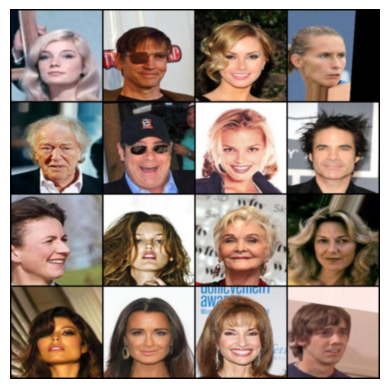

In [9]:
batch, _ = next(iter(celeba_loader))
show(batch[0:16], nrow=4)

In [10]:
# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

# Loss function
adversarial_loss = nn.BCELoss()

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
# Train the VAE
num_epochs = 50
latent_dim=512
# Lists to store losses
G_losses = []
D_losses = []

# Training loop
for epoch in range(num_epochs):
    for i, (imgs, _) in enumerate(celeba_loader):
        
        # Adversarial ground truths
        valid = torch.ones(imgs.size(0), 1)
        fake = torch.zeros(imgs.size(0), 1)
        
        # Train Generator
        optimizer_G.zero_grad()
        
        z = torch.randn(imgs.size(0), latent_dim)
        gen_imgs = generator(z)
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()
        
        real_loss = adversarial_loss(discriminator(imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        
        d_loss.backward()
        optimizer_D.step()
        
        # Store losses
        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())
        
        # Print progress
        if i % 100 == 0:
            print(
                f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(celeba_loader)}] "
                f"[D loss: {d_loss.item()}] [G loss: {g_loss.item()}]"
            )
            with torch.no_grad():
                gen_imgs = generator(z)
                #gen_imgs = 0.5 * gen_imgs + 0.5  # denormalize
                gen_imgs = gen_imgs.permute(0,2,3,1).clip(0,1).detach().numpy()
                fig, axs = plt.subplots(5, 5)
                cnt = 0
                for i in range(5):
                    for j in range(5):
                        axs[i, j].imshow(gen_imgs[cnt])
                        axs[i, j].axis('off')
                        cnt += 1
                plt.savefig(os.path.join("outputs",f"gan_images_epoch_{epoch}.png"))
                plt.close()

    torch.save(generator.state_dict(), os.path.join('checkpoints',f"G_{epoch}.png"))
    torch.save(discriminator.state_dict(), os.path.join('checkpoints',f"D_{epoch}.png"))



[Epoch 0/50] [Batch 0/3166] [D loss: 0.6932668685913086] [G loss: 0.6909970641136169]
[Epoch 0/50] [Batch 100/3166] [D loss: 2.369072675704956] [G loss: 0.016302723437547684]
[Epoch 0/50] [Batch 200/3166] [D loss: 0.028483372181653976] [G loss: 3.7594187259674072]
[Epoch 0/50] [Batch 300/3166] [D loss: 0.04687153548002243] [G loss: 4.174016952514648]
[Epoch 0/50] [Batch 400/3166] [D loss: 1.4714272022247314] [G loss: 2.5491042137145996]
[Epoch 0/50] [Batch 500/3166] [D loss: 0.5278130769729614] [G loss: 0.777410626411438]
[Epoch 0/50] [Batch 600/3166] [D loss: 0.03068450093269348] [G loss: 3.1548757553100586]
[Epoch 0/50] [Batch 700/3166] [D loss: 0.5331079959869385] [G loss: 0.9488205909729004]
[Epoch 0/50] [Batch 800/3166] [D loss: 0.4375881552696228] [G loss: 1.8357594013214111]
[Epoch 0/50] [Batch 900/3166] [D loss: 0.42723050713539124] [G loss: 1.5534794330596924]
[Epoch 0/50] [Batch 1000/3166] [D loss: 0.4623948037624359] [G loss: 1.0810149908065796]
[Epoch 0/50] [Batch 1100/3166

[Epoch 2/50] [Batch 2900/3166] [D loss: 0.33161014318466187] [G loss: 1.7917876243591309]
[Epoch 2/50] [Batch 3000/3166] [D loss: 0.3013491630554199] [G loss: 1.9666171073913574]
[Epoch 2/50] [Batch 3100/3166] [D loss: 0.3794858455657959] [G loss: 2.6651346683502197]
[Epoch 3/50] [Batch 0/3166] [D loss: 0.24490705132484436] [G loss: 2.121436595916748]
[Epoch 3/50] [Batch 100/3166] [D loss: 0.2636168599128723] [G loss: 1.63544762134552]
[Epoch 3/50] [Batch 200/3166] [D loss: 0.27741575241088867] [G loss: 1.362383484840393]
[Epoch 3/50] [Batch 300/3166] [D loss: 0.338923841714859] [G loss: 2.223011016845703]
[Epoch 3/50] [Batch 400/3166] [D loss: 0.2581205666065216] [G loss: 1.7530999183654785]
[Epoch 3/50] [Batch 500/3166] [D loss: 0.26551109552383423] [G loss: 1.677252173423767]
[Epoch 3/50] [Batch 600/3166] [D loss: 0.30153417587280273] [G loss: 1.9641315937042236]
[Epoch 3/50] [Batch 700/3166] [D loss: 0.28673070669174194] [G loss: 1.7815314531326294]
[Epoch 3/50] [Batch 800/3166] [D

[Epoch 5/50] [Batch 2600/3166] [D loss: 0.21432287991046906] [G loss: 1.8681809902191162]
[Epoch 5/50] [Batch 2700/3166] [D loss: 0.21628668904304504] [G loss: 2.2516541481018066]
[Epoch 5/50] [Batch 2800/3166] [D loss: 0.18417416512966156] [G loss: 2.989811897277832]
[Epoch 5/50] [Batch 2900/3166] [D loss: 0.2196286916732788] [G loss: 2.743004083633423]
[Epoch 5/50] [Batch 3000/3166] [D loss: 0.18425585329532623] [G loss: 2.0527119636535645]
[Epoch 5/50] [Batch 3100/3166] [D loss: 0.15923753380775452] [G loss: 2.037668466567993]
[Epoch 6/50] [Batch 0/3166] [D loss: 0.1711319386959076] [G loss: 2.2278852462768555]
[Epoch 6/50] [Batch 100/3166] [D loss: 0.16939319670200348] [G loss: 2.6474509239196777]
[Epoch 6/50] [Batch 200/3166] [D loss: 0.2682064175605774] [G loss: 2.2818055152893066]
[Epoch 6/50] [Batch 300/3166] [D loss: 0.20093168318271637] [G loss: 2.1680541038513184]
[Epoch 6/50] [Batch 400/3166] [D loss: 0.23649625480175018] [G loss: 1.7981936931610107]
[Epoch 6/50] [Batch 500

[Epoch 8/50] [Batch 2300/3166] [D loss: 0.3464064598083496] [G loss: 1.7449333667755127]
[Epoch 8/50] [Batch 2400/3166] [D loss: 0.16492992639541626] [G loss: 2.599193572998047]
[Epoch 8/50] [Batch 2500/3166] [D loss: 0.1738761067390442] [G loss: 2.124318838119507]
[Epoch 8/50] [Batch 2600/3166] [D loss: 0.19240190088748932] [G loss: 2.1921215057373047]
[Epoch 8/50] [Batch 2700/3166] [D loss: 0.12018264830112457] [G loss: 3.639354944229126]
[Epoch 8/50] [Batch 2800/3166] [D loss: 0.1925596296787262] [G loss: 3.5111024379730225]
[Epoch 8/50] [Batch 2900/3166] [D loss: 0.12107383459806442] [G loss: 3.127552032470703]
[Epoch 8/50] [Batch 3000/3166] [D loss: 0.2445594072341919] [G loss: 2.12679123878479]
[Epoch 8/50] [Batch 3100/3166] [D loss: 0.11553032696247101] [G loss: 3.1272997856140137]
[Epoch 9/50] [Batch 0/3166] [D loss: 0.13406294584274292] [G loss: 3.7527248859405518]
[Epoch 9/50] [Batch 100/3166] [D loss: 0.15514616668224335] [G loss: 3.248140335083008]
[Epoch 9/50] [Batch 200/3

[Epoch 11/50] [Batch 1900/3166] [D loss: 0.19763357937335968] [G loss: 2.547764539718628]
[Epoch 11/50] [Batch 2000/3166] [D loss: 0.07808288931846619] [G loss: 3.8182339668273926]
[Epoch 11/50] [Batch 2100/3166] [D loss: 0.1299837827682495] [G loss: 2.45395827293396]
[Epoch 11/50] [Batch 2200/3166] [D loss: 0.09565255790948868] [G loss: 3.874257802963257]
[Epoch 11/50] [Batch 2300/3166] [D loss: 0.18254463374614716] [G loss: 2.7467567920684814]
[Epoch 11/50] [Batch 2400/3166] [D loss: 0.10582955181598663] [G loss: 3.826359510421753]
[Epoch 11/50] [Batch 2500/3166] [D loss: 0.08986987173557281] [G loss: 3.982725143432617]
[Epoch 11/50] [Batch 2600/3166] [D loss: 0.10272045433521271] [G loss: 2.4383418560028076]
[Epoch 11/50] [Batch 2700/3166] [D loss: 0.127520352602005] [G loss: 2.888029098510742]
[Epoch 11/50] [Batch 2800/3166] [D loss: 0.18721799552440643] [G loss: 4.06449031829834]
[Epoch 11/50] [Batch 2900/3166] [D loss: 0.12488964200019836] [G loss: 2.718262195587158]
[Epoch 11/50

[Epoch 14/50] [Batch 1500/3166] [D loss: 0.0946718379855156] [G loss: 4.056228160858154]
[Epoch 14/50] [Batch 1600/3166] [D loss: 0.11826309561729431] [G loss: 4.504049777984619]
[Epoch 14/50] [Batch 1700/3166] [D loss: 0.09318806976079941] [G loss: 4.2269673347473145]
[Epoch 14/50] [Batch 1800/3166] [D loss: 0.14950653910636902] [G loss: 4.425940036773682]
[Epoch 14/50] [Batch 1900/3166] [D loss: 0.1257898509502411] [G loss: 2.363452196121216]
[Epoch 14/50] [Batch 2000/3166] [D loss: 0.07982233911752701] [G loss: 3.658994436264038]
[Epoch 14/50] [Batch 2100/3166] [D loss: 0.07926268875598907] [G loss: 2.8807213306427]
[Epoch 14/50] [Batch 2200/3166] [D loss: 0.047781042754650116] [G loss: 3.7809481620788574]
[Epoch 14/50] [Batch 2300/3166] [D loss: 0.07077343016862869] [G loss: 4.473351955413818]
[Epoch 14/50] [Batch 2400/3166] [D loss: 0.10243481397628784] [G loss: 4.170343399047852]
[Epoch 14/50] [Batch 2500/3166] [D loss: 0.09888844937086105] [G loss: 4.776984214782715]
[Epoch 14/5

[Epoch 17/50] [Batch 1100/3166] [D loss: 0.06277450174093246] [G loss: 3.623504400253296]
[Epoch 17/50] [Batch 1200/3166] [D loss: 0.08468934893608093] [G loss: 4.805213451385498]
[Epoch 17/50] [Batch 1300/3166] [D loss: 0.1039169430732727] [G loss: 4.502117156982422]
[Epoch 17/50] [Batch 1400/3166] [D loss: 0.08378998190164566] [G loss: 4.441359519958496]
[Epoch 17/50] [Batch 1500/3166] [D loss: 0.06118299067020416] [G loss: 3.207571268081665]
[Epoch 17/50] [Batch 1600/3166] [D loss: 0.07013934850692749] [G loss: 4.771705150604248]
[Epoch 17/50] [Batch 1700/3166] [D loss: 0.04469684511423111] [G loss: 4.054776668548584]
[Epoch 17/50] [Batch 1800/3166] [D loss: 0.042032450437545776] [G loss: 4.338547229766846]
[Epoch 17/50] [Batch 1900/3166] [D loss: 0.10409826785326004] [G loss: 5.372664451599121]
[Epoch 17/50] [Batch 2000/3166] [D loss: 0.08037735521793365] [G loss: 4.643465042114258]
[Epoch 17/50] [Batch 2100/3166] [D loss: 0.06933000683784485] [G loss: 4.273258209228516]
[Epoch 17/

[Epoch 20/50] [Batch 700/3166] [D loss: 0.05599554255604744] [G loss: 4.0379157066345215]
[Epoch 20/50] [Batch 800/3166] [D loss: 0.04303060844540596] [G loss: 4.953647136688232]
[Epoch 20/50] [Batch 900/3166] [D loss: 0.05820135772228241] [G loss: 5.0775980949401855]
[Epoch 20/50] [Batch 1000/3166] [D loss: 0.0670630931854248] [G loss: 4.5415873527526855]
[Epoch 20/50] [Batch 1100/3166] [D loss: 0.10131329298019409] [G loss: 4.9743170738220215]
[Epoch 20/50] [Batch 1200/3166] [D loss: 0.12035003304481506] [G loss: 3.906581401824951]
[Epoch 20/50] [Batch 1300/3166] [D loss: 0.09419897198677063] [G loss: 5.742720603942871]
[Epoch 20/50] [Batch 1400/3166] [D loss: 0.04902099817991257] [G loss: 5.222916603088379]
[Epoch 20/50] [Batch 1500/3166] [D loss: 0.06022503972053528] [G loss: 5.1304545402526855]
[Epoch 20/50] [Batch 1600/3166] [D loss: 0.05603044480085373] [G loss: 3.8150525093078613]
[Epoch 20/50] [Batch 1700/3166] [D loss: 0.064022496342659] [G loss: 5.434521675109863]
[Epoch 20/

[Epoch 23/50] [Batch 300/3166] [D loss: 0.04652030020952225] [G loss: 4.834892272949219]
[Epoch 23/50] [Batch 400/3166] [D loss: 0.05418770760297775] [G loss: 4.953002452850342]
[Epoch 23/50] [Batch 500/3166] [D loss: 0.2075098752975464] [G loss: 5.961244106292725]
[Epoch 23/50] [Batch 600/3166] [D loss: 0.0565309077501297] [G loss: 4.61673641204834]
[Epoch 23/50] [Batch 700/3166] [D loss: 0.05153551697731018] [G loss: 4.884428977966309]
[Epoch 23/50] [Batch 800/3166] [D loss: 0.028370503336191177] [G loss: 4.967782974243164]
[Epoch 23/50] [Batch 900/3166] [D loss: 0.10741016268730164] [G loss: 2.5775163173675537]
[Epoch 23/50] [Batch 1000/3166] [D loss: 0.09891191869974136] [G loss: 5.016171455383301]
[Epoch 23/50] [Batch 1100/3166] [D loss: 0.12338121235370636] [G loss: 3.7406132221221924]
[Epoch 23/50] [Batch 1200/3166] [D loss: 0.08593950420618057] [G loss: 4.382467269897461]
[Epoch 23/50] [Batch 1300/3166] [D loss: 0.07407697290182114] [G loss: 4.951401233673096]
[Epoch 23/50] [Ba

[Epoch 25/50] [Batch 3100/3166] [D loss: 0.02241506800055504] [G loss: 4.708024978637695]
[Epoch 26/50] [Batch 0/3166] [D loss: 0.03137718141078949] [G loss: 5.595340728759766]
[Epoch 26/50] [Batch 100/3166] [D loss: 0.07028532028198242] [G loss: 3.5114922523498535]
[Epoch 26/50] [Batch 200/3166] [D loss: 0.03018631786108017] [G loss: 4.754572868347168]
[Epoch 26/50] [Batch 300/3166] [D loss: 0.03699073567986488] [G loss: 6.231082916259766]
[Epoch 26/50] [Batch 400/3166] [D loss: 0.00787833146750927] [G loss: 5.827447414398193]
[Epoch 26/50] [Batch 500/3166] [D loss: 0.005283975042402744] [G loss: 6.4169793128967285]
[Epoch 26/50] [Batch 600/3166] [D loss: 0.015183819457888603] [G loss: 5.177833557128906]
[Epoch 26/50] [Batch 700/3166] [D loss: 0.023489631712436676] [G loss: 4.823105335235596]
[Epoch 26/50] [Batch 800/3166] [D loss: 0.0879424661397934] [G loss: 4.537705898284912]
[Epoch 26/50] [Batch 900/3166] [D loss: 0.013752143830060959] [G loss: 5.479015350341797]
[Epoch 26/50] [Ba

[Epoch 28/50] [Batch 2600/3166] [D loss: 0.01005634292960167] [G loss: 13.363638877868652]
[Epoch 28/50] [Batch 2700/3166] [D loss: 0.03991267830133438] [G loss: 6.585155487060547]
[Epoch 28/50] [Batch 2800/3166] [D loss: 0.001603485201485455] [G loss: 11.138200759887695]
[Epoch 28/50] [Batch 2900/3166] [D loss: 0.03513862192630768] [G loss: 8.14296817779541]
[Epoch 28/50] [Batch 3000/3166] [D loss: 0.13143306970596313] [G loss: 6.512409210205078]
[Epoch 28/50] [Batch 3100/3166] [D loss: 0.14021417498588562] [G loss: 33.48543167114258]
[Epoch 29/50] [Batch 0/3166] [D loss: 0.24522659182548523] [G loss: 34.342079162597656]
[Epoch 29/50] [Batch 100/3166] [D loss: 0.04411610960960388] [G loss: 7.695500373840332]
[Epoch 29/50] [Batch 200/3166] [D loss: 0.01029948703944683] [G loss: 7.97107458114624]
[Epoch 29/50] [Batch 300/3166] [D loss: 0.10735876113176346] [G loss: 9.505463600158691]
[Epoch 29/50] [Batch 400/3166] [D loss: 8.139919316363375e-08] [G loss: 22.886240005493164]
[Epoch 29/50

[Epoch 31/50] [Batch 2100/3166] [D loss: 0.05701304227113724] [G loss: 16.3719482421875]
[Epoch 31/50] [Batch 2200/3166] [D loss: 0.9068704843521118] [G loss: 34.75764083862305]
[Epoch 31/50] [Batch 2300/3166] [D loss: 0.08515365421772003] [G loss: 6.452329158782959]
[Epoch 31/50] [Batch 2400/3166] [D loss: 0.09424913674592972] [G loss: 7.443671226501465]
[Epoch 31/50] [Batch 2500/3166] [D loss: 0.0009136666194535792] [G loss: 11.307266235351562]
[Epoch 31/50] [Batch 2600/3166] [D loss: 0.00968980137258768] [G loss: 6.393782615661621]
[Epoch 31/50] [Batch 2700/3166] [D loss: 0.25034189224243164] [G loss: 8.081618309020996]
[Epoch 31/50] [Batch 2800/3166] [D loss: 0.06187889724969864] [G loss: 16.25475311279297]
[Epoch 31/50] [Batch 2900/3166] [D loss: 0.06045425683259964] [G loss: 4.542210578918457]
[Epoch 31/50] [Batch 3000/3166] [D loss: 0.02699780836701393] [G loss: 17.652061462402344]
[Epoch 31/50] [Batch 3100/3166] [D loss: 0.07377059757709503] [G loss: 13.905143737792969]
[Epoch 

[Epoch 34/50] [Batch 1600/3166] [D loss: 1.0216754999515095e-39] [G loss: 99.37394714355469]
[Epoch 34/50] [Batch 1700/3166] [D loss: 8.50644219783737e-41] [G loss: 99.80332946777344]
[Epoch 34/50] [Batch 1800/3166] [D loss: 2.826499408614574e-26] [G loss: 82.69927215576172]
[Epoch 34/50] [Batch 1900/3166] [D loss: 2.693595932021996e-24] [G loss: 81.9393310546875]
[Epoch 34/50] [Batch 2000/3166] [D loss: 0.0] [G loss: 100.0]
[Epoch 34/50] [Batch 2100/3166] [D loss: 0.0] [G loss: 100.0]
[Epoch 34/50] [Batch 2200/3166] [D loss: 0.0] [G loss: 100.0]
[Epoch 34/50] [Batch 2300/3166] [D loss: 0.0] [G loss: 100.0]
[Epoch 34/50] [Batch 2400/3166] [D loss: 0.0] [G loss: 100.0]
[Epoch 34/50] [Batch 2500/3166] [D loss: 0.0] [G loss: 100.0]
[Epoch 34/50] [Batch 2600/3166] [D loss: 0.0] [G loss: 100.0]
[Epoch 34/50] [Batch 2700/3166] [D loss: 0.0] [G loss: 100.0]
[Epoch 34/50] [Batch 2800/3166] [D loss: 0.0] [G loss: 100.0]
[Epoch 34/50] [Batch 2900/3166] [D loss: 0.0] [G loss: 100.0]
[Epoch 34/50]

[Epoch 38/50] [Batch 1800/3166] [D loss: 0.0] [G loss: 100.0]
[Epoch 38/50] [Batch 1900/3166] [D loss: 0.0] [G loss: 100.0]
[Epoch 38/50] [Batch 2000/3166] [D loss: 0.0] [G loss: 100.0]
[Epoch 38/50] [Batch 2100/3166] [D loss: 0.0] [G loss: 100.0]
[Epoch 38/50] [Batch 2200/3166] [D loss: 0.0] [G loss: 100.0]
[Epoch 38/50] [Batch 2300/3166] [D loss: 0.0] [G loss: 100.0]
[Epoch 38/50] [Batch 2400/3166] [D loss: 0.0] [G loss: 100.0]
[Epoch 38/50] [Batch 2500/3166] [D loss: 0.0] [G loss: 100.0]
[Epoch 38/50] [Batch 2600/3166] [D loss: 0.0] [G loss: 100.0]
[Epoch 38/50] [Batch 2700/3166] [D loss: 0.0] [G loss: 100.0]
[Epoch 38/50] [Batch 2800/3166] [D loss: 0.0] [G loss: 100.0]
[Epoch 38/50] [Batch 2900/3166] [D loss: 0.0] [G loss: 100.0]
[Epoch 38/50] [Batch 3000/3166] [D loss: 0.0] [G loss: 100.0]
[Epoch 38/50] [Batch 3100/3166] [D loss: 0.0] [G loss: 100.0]
[Epoch 39/50] [Batch 0/3166] [D loss: 0.0] [G loss: 100.0]
[Epoch 39/50] [Batch 100/3166] [D loss: 0.0] [G loss: 100.0]
[Epoch 39/50

[Epoch 42/50] [Batch 2300/3166] [D loss: 0.0] [G loss: 100.0]
[Epoch 42/50] [Batch 2400/3166] [D loss: 0.0] [G loss: 100.0]
[Epoch 42/50] [Batch 2500/3166] [D loss: 0.0] [G loss: 100.0]
[Epoch 42/50] [Batch 2600/3166] [D loss: 0.0] [G loss: 100.0]
[Epoch 42/50] [Batch 2700/3166] [D loss: 0.0] [G loss: 100.0]
[Epoch 42/50] [Batch 2800/3166] [D loss: 0.0] [G loss: 100.0]
[Epoch 42/50] [Batch 2900/3166] [D loss: 0.0] [G loss: 100.0]
[Epoch 42/50] [Batch 3000/3166] [D loss: 0.0] [G loss: 100.0]
[Epoch 42/50] [Batch 3100/3166] [D loss: 0.0] [G loss: 100.0]
[Epoch 43/50] [Batch 0/3166] [D loss: 0.0] [G loss: 100.0]
[Epoch 43/50] [Batch 100/3166] [D loss: 0.0] [G loss: 100.0]
[Epoch 43/50] [Batch 200/3166] [D loss: 0.0] [G loss: 100.0]
[Epoch 43/50] [Batch 300/3166] [D loss: 0.0] [G loss: 100.0]
[Epoch 43/50] [Batch 400/3166] [D loss: 0.0] [G loss: 100.0]
[Epoch 43/50] [Batch 500/3166] [D loss: 0.0] [G loss: 100.0]
[Epoch 43/50] [Batch 600/3166] [D loss: 0.0] [G loss: 100.0]
[Epoch 43/50] [Ba

[Epoch 46/50] [Batch 2700/3166] [D loss: 0.0] [G loss: 100.0]
[Epoch 46/50] [Batch 2800/3166] [D loss: 0.0] [G loss: 100.0]
[Epoch 46/50] [Batch 2900/3166] [D loss: 0.0] [G loss: 100.0]
[Epoch 46/50] [Batch 3000/3166] [D loss: 0.0] [G loss: 100.0]
[Epoch 46/50] [Batch 3100/3166] [D loss: 0.0] [G loss: 100.0]
[Epoch 47/50] [Batch 0/3166] [D loss: 0.0] [G loss: 100.0]
[Epoch 47/50] [Batch 100/3166] [D loss: 0.0] [G loss: 100.0]
[Epoch 47/50] [Batch 200/3166] [D loss: 0.0] [G loss: 100.0]
[Epoch 47/50] [Batch 300/3166] [D loss: 0.0] [G loss: 100.0]
[Epoch 47/50] [Batch 400/3166] [D loss: 0.0] [G loss: 100.0]
[Epoch 47/50] [Batch 500/3166] [D loss: 0.0] [G loss: 100.0]
[Epoch 47/50] [Batch 600/3166] [D loss: 0.0] [G loss: 100.0]
[Epoch 47/50] [Batch 700/3166] [D loss: 0.0] [G loss: 100.0]
[Epoch 47/50] [Batch 800/3166] [D loss: 0.0] [G loss: 100.0]
[Epoch 47/50] [Batch 900/3166] [D loss: 0.0] [G loss: 100.0]
[Epoch 47/50] [Batch 1000/3166] [D loss: 0.0] [G loss: 100.0]
[Epoch 47/50] [Batch

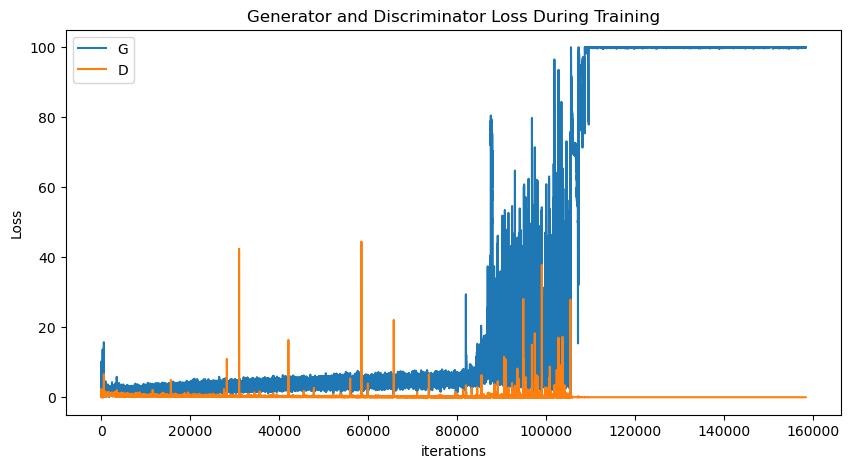

In [13]:
# Display losses
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
np.save('G_losses.npy',G_losses)
np.save('D_losses.npy',D_losses)